In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity


print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
from src.models import naive_dec

plt.style.use('./notebooks/tutorial_style.txt')

Current path: /home/ubuntu/BrainDecoding


In [22]:
directory_random = "outputs/HT/random"
directory_MT = "outputs/HT/base"

In [23]:
def plot_accuracy(directory_random, directory_MT, ax): 
    dirinhos = [directory_random, directory_MT]
    dirs_random = sorted(os.listdir(directory_random))
    dirs_MT = os.listdir(directory_MT)
    for idx, dir_list in enumerate([dirs_random, dirs_MT]):
        dir_list = sorted(dir_list)
        plot_data = []
        for i, dir in enumerate(dir_list):
            test_raw = torch.load(os.path.join(dirinhos[idx], dir, "test_outputs.pt"))
            test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]

            for subject in torch.unique(test_subjects):
                test_mask = test_subjects == subject
                if test_mask.sum() > 0:
                    test_acc = accuracy_score(test_labels[test_mask], torch.argmax(test_outputs[test_mask], dim=1))

                    plot_data.append({
                        "Run": i,
                        "Subject": int(subject),
                        "Accuracy": test_acc,
                        "Set": "Test"
                    })

        df = pd.DataFrame(plot_data)

        subject_stats = df.groupby("Subject")["Accuracy"].agg(['mean', 'std']).reset_index()

        subject_stats["Condition"] = "Shuffled Labels" if idx == 0 else "Correct Labels"

        sns.boxplot(x="Condition", y="mean", data=subject_stats, showfliers=False, ax=ax, color="white")


        x_positions = np.linspace(-0.20, 0.2, len(subject_stats)+1)
        x_positions = np.delete(x_positions, 0)
        palette = sns.color_palette("tab10", len(subject_stats))
        for i, row in subject_stats.iterrows():
            ax.errorbar(
                x=idx + x_positions[i],
                y=row["mean"],
                yerr=row["std"],
                fmt='o',
                color=palette[i],
                capsize=3,
                markersize=5,
                elinewidth=1,
            )

        ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.7, zorder=10000)

        overall_mean = subject_stats["mean"].mean()
        ax.scatter(
            x=idx,
            y=overall_mean,
            color='black',
            marker='X',
            s=50,
            zorder=10000,
        )
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("")
    parents = [f"outputs/MT1/MT_{i}" for i in range(1, 2)]
    plot_data = []
    for idx, parent in enumerate(parents):
        directories = sorted(os.listdir(parent))
        for d in directories:
            dir = os.path.join(parent, d)
            try:
                test_raw = torch.load(os.path.join(dir, "test_outputs.pt"))
            except FileNotFoundError:
                print(f"File not found: {os.path.join(dir, 'test_outputs.pt')}")
                continue
            test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]
            acc = accuracy_score(test_labels, torch.argmax(test_outputs, dim=1))
            plot_data.append({
                            "Run": idx,
                            "Subject": int(test_subjects[0]),
                            "Accuracy": acc,
                            "Set": "Test"
                        })
    df = pd.DataFrame(plot_data)
    df = df.sort_values(by="Subject")
    print(df)
    subject_stats = df.groupby("Subject")["Accuracy"].agg(['mean', 'std']).reset_index()

    idx = 2

    subject_stats["Condition"] = "Single Subject Run"

    sns.boxplot(x="Condition", y="mean", data=subject_stats, showfliers=False, ax=ax, color="white")


    x_positions = np.linspace(-0.20, 0.2, len(subject_stats)+1)
    x_positions = np.delete(x_positions, 0)
    palette = sns.color_palette("tab10", len(subject_stats))
    for i, row in subject_stats.iterrows():
        ax.errorbar(
            x=idx + x_positions[i],
            y=row["mean"],
            yerr=row["std"],
            fmt='o',
            color=palette[i],
            capsize=3,
            markersize=5,
            elinewidth=1,
        )

    ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.7, zorder=10000)

    overall_mean = subject_stats["mean"].mean()
    ax.scatter(
        x=idx,
        y=overall_mean,
        color='black',
        marker='X',
        s=50,
        zorder=10000,
    )
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("")

   Run  Subject  Accuracy   Set
2    0        2  0.500000  Test
3    0        4  0.340000  Test
4    0        5  0.529412  Test
5    0        6  0.500000  Test
6    0        7  0.600000  Test
0    0       10  0.700000  Test
1    0       11  0.500000  Test


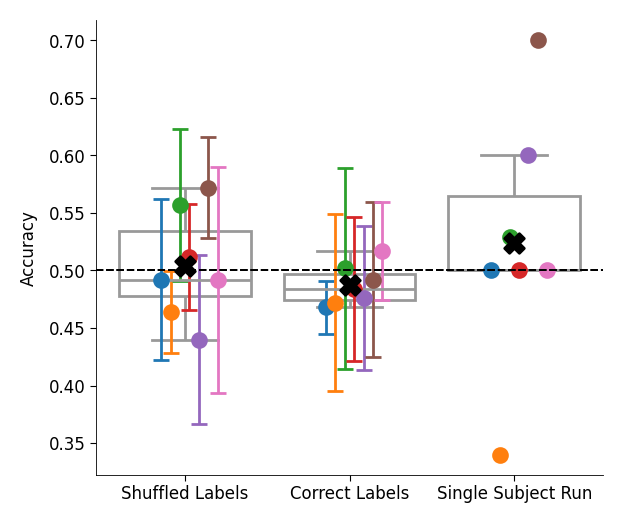

In [24]:
fig = plt.figure(layout='constrained', figsize=(3, 2.5), dpi=200)
ax = fig.subplot_mosaic(
  """
  A
  """,
  width_ratios=[1],
  height_ratios=[1],
)

plot_accuracy(directory_random, directory_MT, ax["A"])

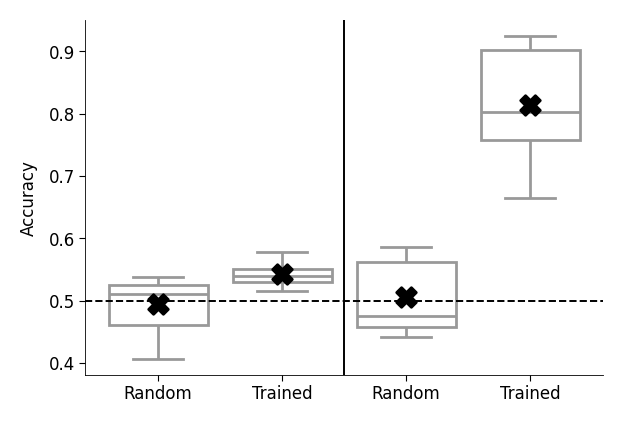

In [25]:
y_random = np.random.normal(0.5, 0.05, 15)
y_random2 = np.random.normal(0.5, 0.06, 15)
y_trained1 = np.random.normal(0.55, 0.03, 15)
y_trained2 = np.random.normal(0.8, 0.07, 15)

fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
sns.boxplot(x=0, y=y_random, color="white", showfliers=False)
sns.boxplot(x=1, y=y_trained1, color="white", showfliers=False)
sns.boxplot(x=2, y=y_random2, color="white", showfliers=False)
sns.boxplot(x=3, y=y_trained2, color="white", showfliers=False)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["Random", "Trained", "Random", "Trained"])
ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.7, zorder=10000)
ax.axvline(x=1.5, color="black", linestyle="-", linewidth=0.7, zorder=10000)
ax.set_ylabel("Accuracy")
# plot mean of each group

for i, y in enumerate([y_random, y_trained1, y_random2, y_trained2]):
    mean = np.mean(y)
    ax.scatter(
        x=i,
        y=mean,
        color='black',
        marker='X',
        s=50,
        zorder=10000,
    )